In [11]:
import numpy as np
import matplotlib.pyplot as plt

# RecencyAdMDP

## def

In [84]:
class RecencyAdMDP():
    p_a: list
    max_recency: int
    reward = 1
    gamma = 0.9
    def __init__(self, p_a, max_recency):
        self.p_a = p_a
        self.max_recency = max_recency
    
    def policy_evaluation(self, pi_s, max_iter=100, threashold=0.1):
        g = self.gamma
        r = self.reward
        p0 = self.p_a[0]
        p1 = self.p_a[1]        
        v_s = np.zeros(self.max_recency)
        q_s_a = np.zeros([self.max_recency, 2])
        delta = 1000
        li = []
        for it in range(max_iter):
            for recency in range(self.max_recency):
                v = v_s[recency]
                v0 = v_s[0] ## value when purchase occurs
                if recency == self.max_recency-1:
                    v1 = 0  ## value of dropout state is zero
                else:
                    v1 = v_s[recency+1] ## value when purchase doesn't occur
                q_s_a[recency, 0] = p0 * (r + g * v0) + (1-p0) * g * v1
                q_s_a[recency, 1] = p1 * (    g * v0) + (1-p1) * g * v1
                v_s[recency] = q_s_a[recency, pi_s[recency]]
                delta = np.min([delta, np.abs(v-v_s[recency])])
            if delta<threashold:
                return li
            li.append({"delta": delta, "iteration": it, "v_pi": np.array(v_s), "q_pi": np.array(q_s_a)})
        print("convergence failed.")
        return li

    def policy_improvement(self, q_pi_s_a):
        return np.array([np.argmax(q_pi_s_a[recency, :]) for recency in range(self.max_recency)])

    def policy_iteration(self, initial_pi_s, max_iter=100, threashold=0.1):
        pi_s = np.array(initial_pi_s)
        li = []
        for it in range(10):
            eval_li = res_evaluation = self.policy_evaluation(pi_s, max_iter=max_iter, threashold=threashold)
            new_pi_s = self.policy_improvement(eval_li[-1]["q_pi"])
            li.append({"iter": it, "pi_s": pi_s, "eval_li": eval_li})
            if np.sum(np.abs(pi_s-new_pi_s)) == 0:
                return li
            pi_s = new_pi_s
        print("policy_iteration convergence failed.")
        return li


## test calc

In [98]:
max_recency = 11
pi_s = [0] * 5 + [1] * (max_recency-5)
model = RecencyAdMDP(p_a=[0.1, 0.4], max_recency=max_recency)

[0 0 0 0 0 1 1 1 1 1 1]
[[0.78471386 0.69098977]
 [0.76138048 0.67633448]
 [0.73218534 0.65687105]
 [0.69608244 0.63280245]
 [0.65144637 0.60304507]
 [0.64128412 0.59627024]
 [0.62232079 0.58362802]
 [0.58696933 0.56006037]
 [0.52112385 0.51616339]
 [0.39857173 0.43446198]
 [0.17062425 0.28249699]]
[0 0 0 0 0 0 0 0 0 1 1]


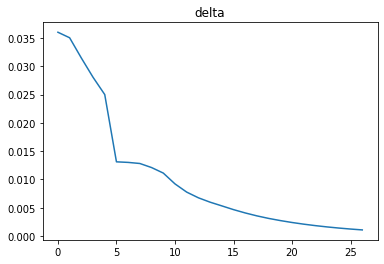

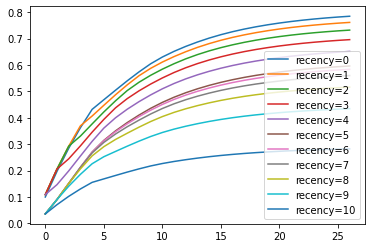

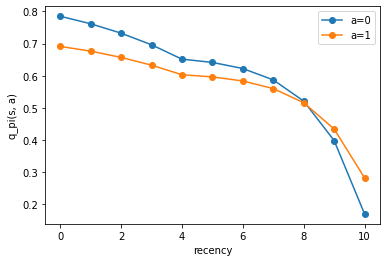

In [99]:
li = model.policy_evaluation(pi_s=pi_s, threashold=0.001)
print(np.array(pi_s))
print(li[-1]["q_pi"])
print(model.policy_improvement(li[-1]["q_pi"]))
xs = np.array([el["delta"] for el in li])
plt.plot(xs)
plt.title("delta")
plt.show()

xss = np.array([el["v_pi"] for el in li])
for recency in range(max_recency):
    plt.plot(xss[:, recency], label=f"recency={recency}")
plt.legend()
plt.show()

el = li[-1]
q_s_a = np.array([el["q_pi"] for el in li])[-1, :, :]
for a in [0, 1]:
    plt.plot(q_s_a[:, a], "o-", label=f"a={a}")
plt.xlabel("recency")
plt.ylabel("q_pi(s, a)")
plt.legend()

deltaが急激に０に向かっており、それぞれの状態のrecencyも値が落ち着いている。収束計算が正しく実行されているとみて間違いない。

recencyごとにv_pi(s)の順番が並んでおり、これも直感通り。

q_pi(s, a=0)とq_pi(s, a=1)の差が非常に小さくなっている。これは、厳密に等しいのかもしれない。

recencyが<=6の状態では、a=0の方が価値が高い。つまり、広告は打つべきではない。しかし、recencyが7<=では、離脱状態に近づいており、広告を打つべきことを示唆する。

In [100]:
li = model.policy_iteration(initial_pi_s=pi_s, max_iter=100, threashold=0.0001)
[[el["iter"], el["pi_s"]] for el in li]

[[0, array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])],
 [1, array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1])],
 [2, array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1])]]

収束した。これで、今回の計算条件における最適解がもとまった

array([[0.86966452, 0.773917  ],
       [0.85390236, 0.76350093],
       [0.83440035, 0.75049959],
       [0.81031488, 0.73444261],
       [0.78057026, 0.71461286],
       [0.74383833, 0.69012491],
       [0.69847931, 0.65988556],
       [0.64246868, 0.62254514],
       [0.5686114 , 0.57330695],
       [0.43177452, 0.48208237],
       [0.17826981, 0.31307923]])

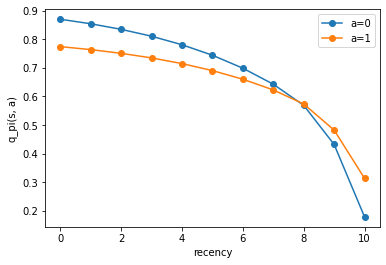

In [101]:
q_s_a = li[-1]["eval_li"][-1]["q_pi"]
display(q_s_a)
for a in [0, 1]:
    plt.plot(q_s_a[:, a], "o-", label=f"a={a}")
plt.xlabel("recency")
plt.ylabel("q_pi(s, a)")
plt.legend()

## compare parameters

In [103]:
max_recency = 11
p0 = 0.1
li = []
for p1 in np.linspace(0.1, 0.5, 20):
    model = RecencyAdMDP(p_a=[p0, p1], max_recency=max_recency)
    pi_s = [0] * 5 + [1] * (max_recency-5)
    res_li = model.policy_iteration(initial_pi_s=pi_s, max_iter=100, threashold=0.0001)
    pi_s = res_li[-1]["pi_s"]
    li.append({
        "p1": p1,
        "pi_s": pi_s})

Text(0, 0.5, 'sum of ad')

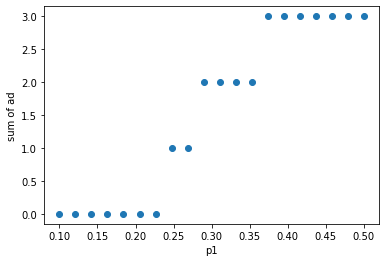

In [110]:
p1 = [el["p1"] for el in li]
sum_a = [np.sum(el["pi_s"]) for el in li]
plt.plot(p1, sum_a, "o")
plt.xlabel("p1")
plt.ylabel("sum of ad")